# Human In The Loop

---
*References:*
- https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/add-human-in-the-loop/#enable-human-intervention

---

Motivations for `human-in-the-loop`:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

LangGraph offers several ways to get or update agent state to support various `human-in-the-loop` workflows.

We will introduce [*dynamic interrupts*](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/add-human-in-the-loop/#pause-using-interrupt), which are *the recommended way* of pausing graph workflows. 

There exist also static breakpoints, or [*static interrupts*](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/add-human-in-the-loop/#debug-with-interrupts). This is an approach that is explicitly *not recommended for human-in-the-loop workflows*, and recommended instead for debugging or testing. For this reason, we will not go over it.

In [2]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai 

In [3]:
from dotenv import load_dotenv

load_dotenv("envs/no_tracing.env")

True

## Dynamic Interrupts - the `interrupt` primitive

Now that we saw the old implementation, let's see how to implement the same thing in new standard practice in LangGraph.  

The workflow is similar to the `InjectedState` - `Command` standard: this time **we must couple an `interrupt` primitive to stop our graph and a `Command.resume` to restart it**.

These that we are seeing now are actually called *dynamic interrupts* or *dynamic breakpoints*, because they are internally managed by the graph, based on its current state.

### 1 Example

To use `interrupt`, we must:

1. Specify a checkpointer to save the graph state after each step.
2. Call `interrupt()` in the appropriate place (we'll see how) 
3. Run the graph with a thread ID until the interrupt is hit.
4. Resume execution using invoke/stream (using the `Command` primitive).


Let's see an example direclt from LangGraph API's documentation:

In [ ]:
from typing import TypedDict
import uuid
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph

from langgraph.types import interrupt, Command


class State(TypedDict):
    some_text: str


def human_node(state: State):
    value = interrupt(      # interrupt(...) pauses execution at human_node, surfacing the given payload to a human.
        {
            "text_to_revise": state["some_text"]  
        }
    )
    return {
        "some_text": value  
    }


# Build the graph
graph_builder = StateGraph(State)
graph_builder.add_node("human_node", human_node)
graph_builder.add_edge(START, "human_node")
checkpointer = InMemorySaver()  # in memory: in production use a database as we saw earlier
graph = graph_builder.compile(checkpointer=checkpointer)
# Pass a thread ID to the graph to run it.
config = {"configurable": {"thread_id": uuid.uuid4()}}
# Run the graph until the interrupt is hit.
result = graph.invoke({"some_text": "original text"}, config=config)  


When the graph hits the interrupt, it returns an Interrupt object with the payload and metadata:

In [ ]:
print(result['__interrupt__']) 

[Interrupt(value={'text_to_revise': 'original text'}, id='061d4d07bc3c097ce66aff070deb8d8d')]


> **Note:** Interrupts resemble Python's `input()` function in terms of developer experience, but they do not automatically resume execution from the interruption point. Instead, they rerun the entire node where the interrupt was used. For this reason, interrupts are typically best placed at the start of a node or in a dedicated node.

To resume execution, use the `Command` primitive, which can be supplied via the `invoke` or `stream` methods. 

The graph resumes execution from the beginning of the node where `interrupt(...)` was initially called. 

This time, the interrupt function will return the value provided in `Command(resume=value)` rather than pausing again. 

All code from the beginning of the node to the interrupt will be re-executed.

In [ ]:
print(graph.invoke(Command(resume="Edited text"), config=config)) 

{'some_text': 'Edited text'}


In [15]:
graph.get_state(config=config)

StateSnapshot(values={'some_text': 'Edited text'}, next=(), config={'configurable': {'thread_id': '24f7007a-a6d9-4a62-9afd-2acf573f2e29', 'checkpoint_ns': '', 'checkpoint_id': '1f08a2fe-8f2b-6611-8001-05546c2304db'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}, 'thread_id': '24f7007a-a6d9-4a62-9afd-2acf573f2e29'}, created_at='2025-09-05T08:11:22.480158+00:00', parent_config={'configurable': {'thread_id': '24f7007a-a6d9-4a62-9afd-2acf573f2e29', 'checkpoint_ns': '', 'checkpoint_id': '1f08a2fe-8ea8-6df3-8000-9bb8084b81ea'}}, tasks=(), interrupts=())

### 2. Resume multiple interrupts with one invocation

When nodes with interrupt conditions are run in parallel, it's possible to have multiple interrupts in the task queue.

Once your graph has been interrupted and is stalled, you can resume all the interrupts at once with `Command.resume`, passing a dictionary mapping of interrupt ids to resume values.

In [27]:
from typing import TypedDict
import uuid
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command


class State(TypedDict):
    text_1: str
    text_2: str


def human_node_1(state: State):
    value = interrupt({"text_to_revise": state["text_1"]})
    return {"text_1": value}


def human_node_2(state: State):
    value = interrupt({"text_to_revise": state["text_2"]})
    return {"text_2": value}


graph_builder = StateGraph(State)
graph_builder.add_node("human_node_1", human_node_1)
graph_builder.add_node("human_node_2", human_node_2)

# Add both nodes in parallel from START
graph_builder.add_edge(START, "human_node_1")
graph_builder.add_edge(START, "human_node_2")

checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

thread_id = str(uuid.uuid4())
config: RunnableConfig = {"configurable": {"thread_id": thread_id}}
result = graph.invoke(
    {"text_1": "original text 1", "text_2": "original text 2"}, config=config
)

graph.get_state(config=config)

StateSnapshot(values={'text_1': 'original text 1', 'text_2': 'original text 2'}, next=('human_node_1', 'human_node_2'), config={'configurable': {'thread_id': 'a26650fa-9a38-4d47-8297-dc925b38b0f8', 'checkpoint_ns': '', 'checkpoint_id': '1f08a34f-1d02-6a71-8000-c5829147ba52'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}, 'thread_id': 'a26650fa-9a38-4d47-8297-dc925b38b0f8'}, created_at='2025-09-05T08:47:24.836913+00:00', parent_config={'configurable': {'thread_id': 'a26650fa-9a38-4d47-8297-dc925b38b0f8', 'checkpoint_ns': '', 'checkpoint_id': '1f08a34f-1cff-6ca8-bfff-da9fbc6a2c9e'}}, tasks=(PregelTask(id='45eec26d-8bd2-1d2a-1d79-ae0aee2a05b8', name='human_node_1', path=('__pregel_pull', 'human_node_1'), error=None, interrupts=(Interrupt(value={'text_to_revise': 'original text 1'}, id='91a6ed5e808a26f759a705c3638b32e1'),), state=None, result=None), PregelTask(id='18f7a0ea-93e1-4c8b-e108-cf2372beda27', name='human_node_2', path=('__pregel_pull', 'human_node_2'), error=None, interr

In [28]:
# Resume with mapping of interrupt IDs to values
resume_map = {
    i.id: f"human input for {i.value}"
    for i in graph.get_state(config=config).interrupts
}
print(graph.invoke(Command(resume=resume_map), config=config))

{'text_1': "human input for {'text_to_revise': 'original text 1'}", 'text_2': "human input for {'text_to_revise': 'original text 2'}"}


In [29]:
graph.get_state(config=config)

StateSnapshot(values={'text_1': "human input for {'text_to_revise': 'original text 1'}", 'text_2': "human input for {'text_to_revise': 'original text 2'}"}, next=(), config={'configurable': {'thread_id': 'a26650fa-9a38-4d47-8297-dc925b38b0f8', 'checkpoint_ns': '', 'checkpoint_id': '1f08a34f-3d24-6eab-8001-5c03e8f1d0b7'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}, 'thread_id': 'a26650fa-9a38-4d47-8297-dc925b38b0f8'}, created_at='2025-09-05T08:47:28.206380+00:00', parent_config={'configurable': {'thread_id': 'a26650fa-9a38-4d47-8297-dc925b38b0f8', 'checkpoint_ns': '', 'checkpoint_id': '1f08a34f-1d02-6a71-8000-c5829147ba52'}}, tasks=(), interrupts=())

### 3 Common patterns 

Below we show different design patterns that can be implemented using `interrupt` and `Command`

#### Approval or rejection

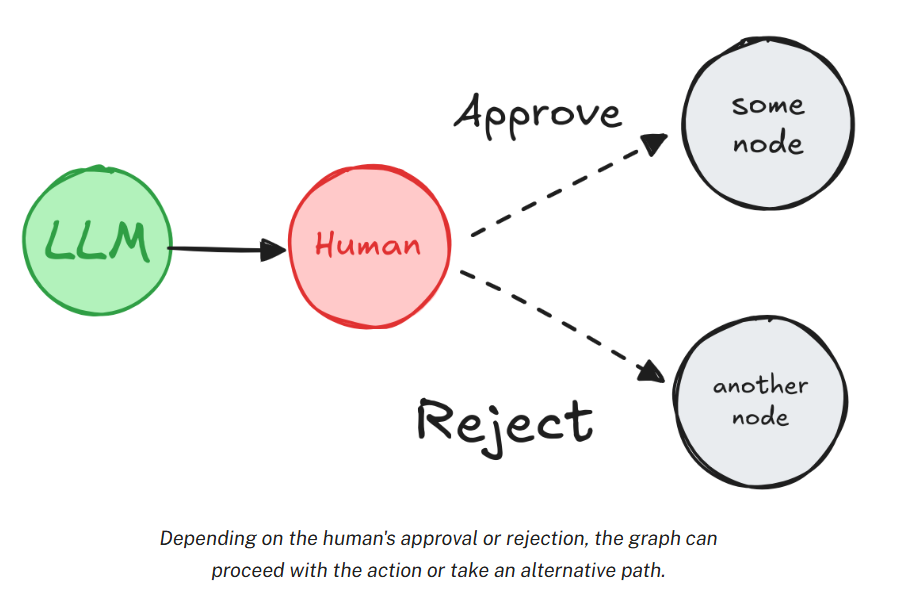

Pause the graph before a critical step, such as an API call, to review and approve the action. 

If the action is rejected, you can prevent the graph from executing the step, and potentially take an alternative action.

In [30]:
from typing import Literal, TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver

# Define the shared graph state
class State(TypedDict):
    llm_output: str
    decision: str

# Simulate an LLM output node
def generate_llm_output(state: State) -> State:
    return {"llm_output": "This is the generated output."}

# Human approval node
def human_approval(state: State) -> Command[Literal["approved_path", "rejected_path"]]:
    decision = interrupt({
        "question": "Do you approve the following output?",
        "llm_output": state["llm_output"]
    })

    if decision == "approve":
        return Command(goto="approved_path", update={"decision": "approved"})
    else:
        return Command(goto="rejected_path", update={"decision": "rejected"})

# Next steps after approval
def approved_node(state: State) -> State:
    print("✅ Approved path taken.")
    return state

# Alternative path after rejection
def rejected_node(state: State) -> State:
    print("❌ Rejected path taken.")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_llm_output", generate_llm_output)
builder.add_node("human_approval", human_approval)
builder.add_node("approved_path", approved_node)
builder.add_node("rejected_path", rejected_node)

builder.set_entry_point("generate_llm_output")
builder.add_edge("generate_llm_output", "human_approval")
builder.add_edge("approved_path", END)
builder.add_edge("rejected_path", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

# Run until interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)
print(result["__interrupt__"])

[Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': 'This is the generated output.'}, id='66e45ef0e03e01403a0231145fcd497c')]


In [31]:
# Simulate resuming with human input
# To test rejection, replace resume="approve" with resume="reject"
final_result = graph.invoke(Command(resume="approve"), config=config)
print(final_result)

✅ Approved path taken.
{'llm_output': 'This is the generated output.', 'decision': 'approved'}


#### Review and edit state

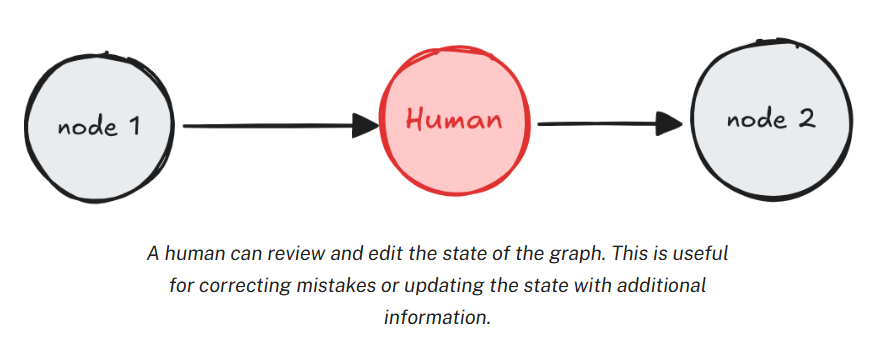

In [32]:
from typing import TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver

# Define the graph state
class State(TypedDict):
    summary: str

# Simulate an LLM summary generation
def generate_summary(state: State) -> State:
    return {
        "summary": "The cat sat on the mat and looked at the stars."
    }

# Human editing node
def human_review_edit(state: State) -> State:
    result = interrupt({
        "task": "Please review and edit the generated summary if necessary.",
        "generated_summary": state["summary"]
    })
    return {
        "summary": result["edited_summary"]
    }

# Simulate downstream use of the edited summary
def downstream_use(state: State) -> State:
    print(f"✅ Using edited summary: {state['summary']}")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_summary", generate_summary)
builder.add_node("human_review_edit", human_review_edit)
builder.add_node("downstream_use", downstream_use)

builder.set_entry_point("generate_summary")
builder.add_edge("generate_summary", "human_review_edit")
builder.add_edge("human_review_edit", "downstream_use")
builder.add_edge("downstream_use", END)

# Set up in-memory checkpointing for interrupt support
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

# Invoke the graph until it hits the interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)

# Output interrupt payload
print(result["__interrupt__"])

[Interrupt(value={'task': 'Please review and edit the generated summary if necessary.', 'generated_summary': 'The cat sat on the mat and looked at the stars.'}, id='f3bdf4a29004094eb17a752536c9a916')]


In [33]:
# Resume the graph with human-edited input
edited_summary = "The cat lay on the rug, gazing peacefully at the night sky."
resumed_result = graph.invoke(
    Command(resume={"edited_summary": edited_summary}),
    config=config
)
print(resumed_result)

✅ Using edited summary: The cat lay on the rug, gazing peacefully at the night sky.
{'summary': 'The cat lay on the rug, gazing peacefully at the night sky.'}


#### Review tool calls

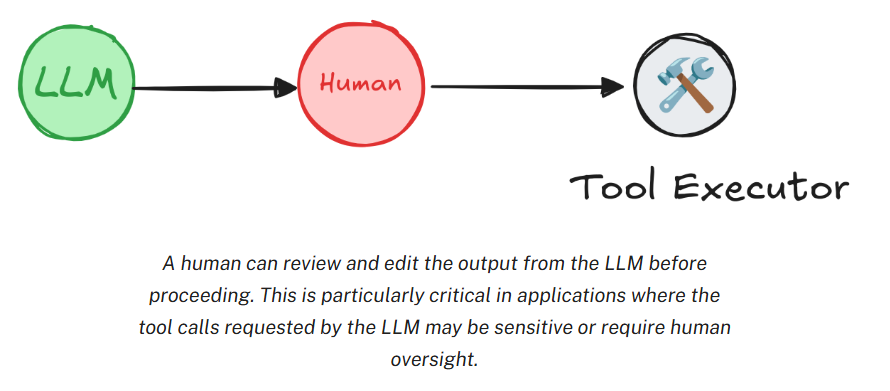

To add a human approval step to a tool:

1. Use `interrupt()` in the tool to pause execution.
2. Resume with a `Command` to continue based on human input.

In [35]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt
from langgraph.prebuilt import create_react_agent

# An example of a sensitive tool that requires human review / approval
def book_hotel(hotel_name: str):
    """Book a hotel"""
    response = interrupt(  
        f"Trying to call `book_hotel` with args {{'hotel_name': {hotel_name}}}. "
        "Please approve or suggest edits."
    )
    if response["type"] == "accept":
        pass
    elif response["type"] == "edit":
        hotel_name = response["args"]["hotel_name"]
    else:
        raise ValueError(f"Unknown response type: {response['type']}")
    return f"Successfully booked a stay at {hotel_name}."

checkpointer = InMemorySaver() 

agent = create_react_agent(
    model="openai:gpt-4o",
    tools=[book_hotel],
    checkpointer=checkpointer, 
)

Stream the agent output, passing the config object to specify the thread ID.

It will run until reaching interruption:

In [36]:
config = {
   "configurable": {
      "thread_id": "1"
   }
}

for chunk in agent.stream(
    {"messages": [{"role": "user", "content": "book a stay at McKittrick hotel"}]},
    config
):
    print(chunk)
    print("\n")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MZlA79anDendC2q25B3sy9WQ', 'function': {'arguments': '{"hotel_name":"McKittrick hotel"}', 'name': 'book_hotel'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 52, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CCMalLXIEGI5MJuiqUUE1z9ixT4eI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--56f0f431-f2df-442c-bb20-bfda643ee21e-0', tool_calls=[{'name': 'book_hotel', 'args': {'hotel_name': 'McKittrick hotel'}, 'id': 'call_MZlA79anDendC2q25B3sy9WQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 52, 'output_tokens': 20, 

Resume the agent with a `Command` to continue based on human input.

In [37]:
from langgraph.types import Command

for chunk in agent.stream(
    Command(resume={"type": "accept"}),  
    # Command(resume={"type": "edit", "args": {"hotel_name": "McKittrick Hotel"}}),
    config
):
    print(chunk)
    print("\n")

{'tools': {'messages': [ToolMessage(content='Successfully booked a stay at McKittrick hotel.', name='book_hotel', id='3f19a754-909b-4e86-9754-aa5e6fa13dac', tool_call_id='call_MZlA79anDendC2q25B3sy9WQ')]}}


{'agent': {'messages': [AIMessage(content='Your stay at the McKittrick Hotel has been successfully booked. Enjoy your stay!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 92, 'total_tokens': 111, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CCMbSaWGTPB53ZJ4evaZ15EknHgOP', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--93aba4ac-2c99-4e3e-a66d-740d9ba4f13b-0', usage_metadata={'input_tokens': 92, 'output_tokens': 19, 'total_tokens': 111, 

More interesting details are available [here](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/add-human-in-the-loop/#review-tool-calls). 